In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
sns.set_theme(font_scale=1.5)
from tqdm import tqdm

### $J = 1$

In [37]:
def Hamiltonian(v):    
    # qb = One_qubit()
    # H = 0.5*(np.kron(qb.Z, qb.I) + np.kron(qb.I, qb.Z)) - \
    #     v/2 * (np.kron(qb.X, qb.X) - np.kron(qb.Y, qb.Y))
    H = np.array([[1, 0, -v], [0, 0, 0], [-v, 0, -1]])
    return H

v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 3))
entropy = np.zeros((len(v_vals_ana), 3))
for index, v in enumerate(v_vals_ana):
    H = Hamiltonian(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

In [38]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, v, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_sdag(0)
    qubit.apply_hadamard(0)
    qubit.apply_sdag(1)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_yy = qubit.measure(number_shots)
    

    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
    constants = np.array([1/2, 1/2, -v/2, v/2])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [39]:
from scipy.optimize import minimize
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


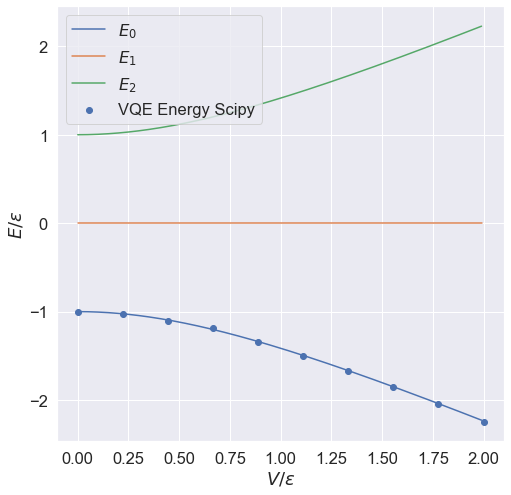

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'upper left')
plt.show()

## J = 2

In [90]:
def Hamiltonian(v):    
    # qb = One_qubit()
    # H = 0.5*(np.kron(qb.Z, qb.I) + np.kron(qb.I, qb.Z)) - \
    #     v/2 * (np.kron(qb.X, qb.X) - np.kron(qb.Y, qb.Y))
    H = np.array([[-2, 0, -np.sqrt(6)*v, 0, 0], 
                  [0, -1, 0, -3*v, 0],
                  [-np.sqrt(6)*v, 0, 0, 0, -np.sqrt(6)*v], 
                  [0, -3*v, 0, 1, 0], 
                  [0, 0, -np.sqrt(6)*v, 0, 2]])
    return H

v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 5))
entropy = np.zeros((len(v_vals_ana), 5))
for index, v in enumerate(v_vals_ana):
    H = Hamiltonian(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

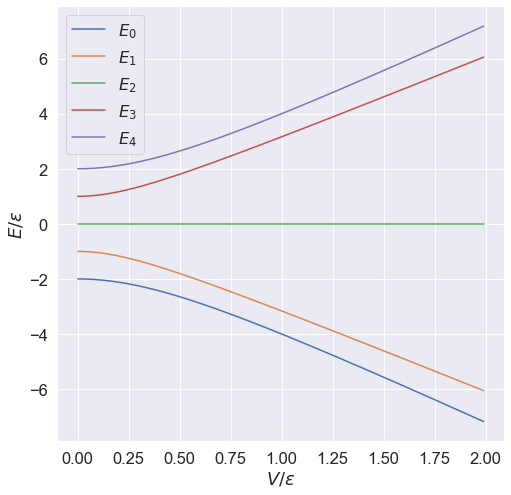

In [91]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'upper left')
plt.show()

## Finding the unitary matrices which rotate the measurement basis

In [92]:
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])
CNOT01 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
CNOT10 = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])


# Z1 = Z I I I 
ZIII = np.kron(Z, np.kron(I, np.kron(I, I))) # this is the measurement basis
IZII = np.kron(I, np.kron(Z, np.kron(I, I)))
IIZI = np.kron(I, np.kron(I, np.kron(Z, I)))
IIIZ = np.kron(I, np.kron(I, np.kron(I, Z)))
U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
print('IZII:')
print(np.sum(np.abs(ZIII - U_IZII.conj().T @ IZII @ U_IZII)))
U_IIZI = np.kron(I, np.kron(np.kron(I, I)@SWAP, I))@U_IZII
print('IIZI:')
print(np.sum(np.abs(ZIII - U_IIZI.conj().T @ IIZI @ U_IIZI)))
U_IIIZ = np.kron(I, np.kron(I, np.kron(I, I)@SWAP))@U_IIZI
print('IIIZ:')
print(np.sum(np.abs(ZIII - U_IIIZ.conj().T @ IIIZ @ U_IIIZ)))

XXII = np.kron(X, np.kron(X, np.kron(I, I)))
XIXI = np.kron(X, np.kron(I, np.kron(X, I)))
XIIX = np.kron(X, np.kron(I, np.kron(I, X)))
IXXI = np.kron(I, np.kron(X, np.kron(X, I)))
IXIX = np.kron(I, np.kron(X, np.kron(I, X)))
IIXX = np.kron(I, np.kron(I, np.kron(X, X)))

# U_XXII = np.kron(CNOT10@np.kron(H, H), np.kron(I, I))
U_XXII = np.kron(np.kron(H, H)@CNOT10, np.kron(I, I))
print('XXII:')
print(np.sum(np.abs(ZIII - U_XXII.conj().T @ XXII @ U_XXII)))

U_XIXI1 = np.kron(H, np.kron(I, np.kron(H, I)))
U_XIXI2 = np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
U_XIXI3 = np.kron(CNOT10, np.kron(I, I))
U_XIXI = U_XIXI1@U_XIXI2@U_XIXI3
print('XIXI:')
print(np.sum(np.abs(ZIII - U_XIXI.conj().T @ XIXI @ U_XIXI)))

U_XIIX1 = np.kron(H, np.kron(I, SWAP@np.kron(H, I)))
U_XIIX = U_XIIX1@U_XIXI2@U_XIXI3
print('XIIX:')
print(np.sum(np.abs(ZIII - U_XIIX.conj().T @ XIIX @ U_XIIX)))

U_IXXI1 = np.kron(SWAP@np.kron(H, I), np.kron(H, I))
U_IXXI = U_IXXI1@U_XIXI2@U_XIXI3
print('IXXI:')
print(np.sum(np.abs(ZIII - U_IXXI.conj().T @ IXXI @ U_IXXI)))

U_IXIX1 = np.kron(SWAP@np.kron(H, I), SWAP@np.kron(H, I))
U_IXIX = U_IXIX1@U_XIXI2@U_XIXI3
print('IXIX:')
print(np.sum(np.abs(ZIII - U_IXIX.conj().T @ IXIX @ U_IXIX)))

U_IIXX1 = np.kron(I, np.kron(I, np.kron(H, H)@CNOT10))
U_IIXX = U_IIXX1@U_IIZI
print('IIXX:')
print(np.sum(np.abs(ZIII - U_IIXX.conj().T @ IIXX @ U_IIXX)))

YYII = np.kron(Y, np.kron(Y, np.kron(I, I)))
YIYI = np.kron(Y, np.kron(I, np.kron(Y, I)))
YIIY = np.kron(Y, np.kron(I, np.kron(I, Y)))
IYYI = np.kron(I, np.kron(Y, np.kron(Y, I)))
IYIY = np.kron(I, np.kron(Y, np.kron(I, Y)))
IIYY = np.kron(I, np.kron(I, np.kron(Y, Y)))

U_YYII = np.kron(np.kron(S@H, S@H)@CNOT10, np.kron(I, I))
print('YYII:')
print(np.sum(np.abs(ZIII - U_YYII.conj().T @ YYII @ U_YYII)))

U_YIYI1 = np.kron(np.kron(S@H, I), np.kron(S@H, I))
U_YIYI = U_YIYI1@U_XIXI2@U_XIXI3
print('YIYI:')
print(np.sum(np.abs(ZIII - U_YIYI.conj().T @ YIYI @ U_YIYI)))

U_YIIY1 = np.kron(np.kron(S@H, I), SWAP@np.kron(S@H, I))
U_YIIY = U_YIIY1@U_XIXI2@U_XIXI3
print('YIIY:')
print(np.sum(np.abs(ZIII - U_YIIY.conj().T @ YIIY @ U_YIIY)))

U_IYYI1 = np.kron(SWAP@np.kron(S@H, I), np.kron(S@H, I))
U_IYYI = U_IYYI1@U_XIXI2@U_XIXI3
print('IYYI:')
print(np.sum(np.abs(ZIII - U_IYYI.conj().T @ IYYI @ U_IYYI)))

U_IYIY1 = np.kron(SWAP@np.kron(S@H, I), SWAP@np.kron(S@H, I))
U_IYIY = U_IYIY1@U_XIXI2@U_XIXI3
print('IYIY:')
print(np.sum(np.abs(ZIII - U_IYIY.conj().T @ IYIY @ U_IYIY)))

U_IIYY1 = np.kron(I, np.kron(I, np.kron(S@H, S@H)@CNOT10))
U_IIYY = U_IIYY1@U_IIZI
print('IIYY:')
print(np.sum(np.abs(ZIII - U_IIYY.conj().T @ IIYY @ U_IIYY)))
# Z2 = I Z I I
# Z3 = I I Z I
# Z4 = I I I Z
# X1X2 = X X I I
# X1X3 = X I X I
# X1X4 = X I I X
# X2X3 = I X X I
# X2X4 = I X I X
# X3X4 = I I X X
# Y1Y2 = Y Y I I
# Y1Y3 = Y I Y I
# Y1Y4 = Y I I Y
# Y2Y3 = I Y Y I
# Y2Y4 = I Y I Y
# Y3Y4 = I I Y Y


IZII:
0
IIZI:
0
IIIZ:
0
XXII:
7.105427357601002e-15
XIXI:
7.105427357601002e-15
XIIX:
7.105427357601002e-15
IXXI:
7.105427357601002e-15
IXIX:
7.105427357601002e-15
IIXX:
7.105427357601002e-15
YYII:
7.105427357601002e-15
YIYI:
7.105427357601002e-15
YIIY:
7.105427357601002e-15
IYYI:
7.105427357601002e-15
IYIY:
7.105427357601002e-15
IIYY:
7.105427357601002e-15


In [93]:
import numpy as np 

class One_qubit:
    def __init__(self):
        self.state = np.zeros(2, dtype=np.complex_)
        self.I = np.eye(2)
        self.Z = np.array([[1, 0], [0, -1]])
        self.X = np.array([[0, 1], [1, 0]])
        self.Y = np.array([[0, -1j], [1j, 0]])
        self.H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
        self.S = np.array([[1, 0], [0, 1j]])

    def set_state(self, state):
        if abs(np.linalg.norm(state) - 1) > 1e-10:
            raise ValueError("The state vector must be normalized.")
        self.state = state

    def apply_hadamard(self):
        self.state = np.dot(self.H, self.state)
        return self.state

    def apply_x(self):
        self.state = np.dot(self.X, self.state)
        return self.state

    def apply_y(self):
        self.state = np.dot(self.Y, self.state)
        return self.state

    def apply_z(self):
        self.state = np.dot(self.Z, self.state)
        return self.state

    def measure(self, num_shots=1):
        prob = np.abs(self.state)**2
        possible = np.arange(len(self.state)) #possible measurement outcomes
        outcome = np.random.choice(possible, p=prob, size = num_shots) #measurement outcome
        self.state = np.zeros_like(self.state) #set state to the measurement outcome
        self.state[outcome[-1]] = 1
        return outcome
    
    def rotate_x(self, theta):
        # implement rotation around x axis
        Rx = np.cos(theta/2) * self.I - 1j * np.sin(theta/2) * self.X
        self.state = np.dot(Rx, self.state)

    def rotate_y(self, phi):    
        # implement rotation around y axis
        Ry = np.cos(phi/2) * self.I - 1j * np.sin(phi/2) * self.Y
        self.state = np.dot(Ry, self.state)
    
class Two_qubit(One_qubit):
    def __init__(self):   
        super().__init__()
        self.state = np.zeros(4, dtype=np.complex_)
        self.CNOT01 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
        self.CNOT10 = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])
        self.SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

        # np.random.seed(0)

    def apply_cnot01(self):
        self.state = np.dot(self.CNOT01, self.state)
        return self.state
    
    def apply_cnot10(self):
        self.state = np.dot(self.CNOT10, self.state)
        return self.state
    
    def apply_swap(self):
        self.state = np.dot(self.SWAP, self.state)
        return self.state
    
    def apply_hadamard(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.H, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, self.H).dot(self.state)
        return self.state

    def apply_sdag(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.S.conj().T, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, self.S.conj().T).dot(self.state)
        return self.state

    def apply_x(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.X, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, self.X).dot(self.state)    
        return self.state

    def apply_y(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.Y, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, self.Y).dot(self.state)
        return self.state
        
    def apply_z(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.Z, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, self.Z).dot(self.state)
        return self.state
        
    def rotate_x(self, theta, qubit):
        Rx = np.cos(theta/2) * self.I - 1j * np.sin(theta/2) * self.X
        if qubit == 0:
            self.state = np.kron(Rx, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, Rx).dot(self.state)
        return self.state

    def rotate_y(self, phi, qubit):    
        # implement rotation around y axis
        Ry = np.cos(phi/2) * self.I - 1j * np.sin(phi/2) * self.Y
        if qubit == 0:
            self.state = np.kron(Ry, self.I).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, Ry).dot(self.state)
        return self.state

class Four_qubit(Two_qubit):
    #This is based on the two qubit class since the Lipkin model at most acts on two qubits at the time
    def __init__(self):
        super().__init__()
        self.state = np.zeros(16, dtype=np.complex_)

    def apply_cnot10(self, qubit1):
        # can only be applied for adjecent qubits
        if qubit1 == 0:
            op = np.kron(self.CNOT10, np.kron(self.I, self.I))
            return np.dot(op, self.state)
        elif qubit1 == 1:
            op = np.kron(I, np.kron(CNOT10, self.I))
            return np.dot(op, self.state)
        elif qubit1 == 2:
            op = np.kron(I, np.kron(self.I, self.CNOT10))
            return np.dot(op, self.state)
        else:
            print('qubit1 must be 0, 1, or 2')   

    def apply_swap(self, qubit1):
         # can only be applied for adjecent qubits
        if qubit1 == 0:
            op = np.kron(self.SWAP, np.kron(self.I, self.I))
            return np.dot(op, self.state)
        elif qubit1 == 1:
            op = np.kron(I, np.kron(SWAP, self.I))
            return np.dot(op, self.state)
        elif qubit1 == 2:
            op = np.kron(I, np.kron(self.I, self.SWAP))
            return np.dot(op, self.state)
        else:
            print('qubit1 must be 0, 1, or 2')   
        
    def apply_hadamard(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.H, np.kron(self.I, np.kron(self.I, self.I))).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, np.kron(self.H, np.kron(self.I, self.I))).dot(self.state)
        elif qubit == 2:
            self.state = np.kron(self.I, np.kron(self.I, np.kron(self.H, self.I))).dot(self.state)
        elif qubit == 3:
            self.state = np.kron(self.I, np.kron(self.I, np.kron(self.I, self.H))).dot(self.state)
        return self.state

    def apply_sdag(self, qubit):
        if qubit == 0:
            self.state = np.kron(self.S.conj().T, np.kron(self.I, np.kron(self.I, self.I))).dot(self.state)
        elif qubit == 1:
            self.state = np.kron(self.I, np.kron(self.S.conj().T, np.kron(self.I, self.I))).dot(self.state)
        elif qubit == 2:
            self.state = np.kron(self.I, np.kron(self.I, np.kron(self.S.conj().T, self.I))).dot(self.state)
        elif qubit == 3:
            self.state = np.kron(self.I, np.kron(self.I, np.kron(self.I, self.S.conj().T))).dot(self.state)
        return self.state

In [94]:
def prepare_state(angles, target = None):
    # angles has the form (theta0, phi0, theta1, phi1, ...)
    qubit = Four_qubit()
    I, X, Y = qubit.I, qubit.X, qubit.Y
    init_state = np.zeros(16)
    init_state[0] = 1
    rotations = []
    for i in range(0, len(angles) - 1, 2):
        theta, phi = angles[i], angles[i+1]
        Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * X
        Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * Y
        rotations.append(Ry@Rx)
    rotate = np.kron(rotations[0], np.kron(rotations[1], np.kron(rotations[2], rotations[3]))) 
    # rotate qubits
    qubit.state = rotate@init_state
    # entangle qubits
    qubit.apply_cnot10(0)
    qubit.apply_cnot10(1)
    qubit.apply_cnot10(2)
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, v, number_shots, target = None):
    init_state = prepare_state(angles, target)
    qubit = Four_qubit()
    SWAP, CNOT10, H, S, I = qubit.SWAP, qubit.CNOT10, qubit.H, qubit.S, qubit.I
    Sdag = S.conj().T

    measures = []
    unitaries = []
    U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
    unitaries.append(U_ZIII)
    U_IZII = np.kron(SWAP@np.kron(I, I), np.kron(I, I))
    unitaries.append(U_IZII)
    U_IIZI = U_IZII@np.kron(I, np.kron(SWAP@np.kron(I, I), I))
    unitaries.append(U_IIZI)
    U_IIZZ = U_IIZI@np.kron(I, np.kron(I, SWAP@np.kron(I,I)))
    unitaries.append(U_IIZZ)

    U_ZIZI = np.kron(I, np.kron(I, CNOT10))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))
    
    U_XX = CNOT10@np.kron(H, H)
    U_XI = np.kron(H, I)
    U_IX = np.kron(H, I)@SWAP
    U_XXII = np.kron(U_XX, np.kron(I, I))
    unitaries.append(U_XXII)
    U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
    unitaries.append(U_XIXI)
    U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
    unitaries.append(U_XIIX)
    U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
    unitaries.append(U_IXXI)
    U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
    unitaries.append(U_IXIX)
    U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
    unitaries.append(U_IIXX)

    U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
    U_YI = np.kron(H@Sdag, I)
    U_IY = np.kron(H@Sdag, I)@SWAP
    U_YYII = np.kron(U_YY, np.kron(I, I))
    unitaries.append(U_YYII)
    U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
    unitaries.append(U_YIYI)
    U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
    unitaries.append(U_YIIY)
    U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
    unitaries.append(U_IYYI)
    U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
    unitaries.append(U_IYIY)
    U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
    unitaries.append(U_IIYY)

    for U in unitaries:
        qubit.set_state(init_state)
        qubit.state = U@qubit.state
        measure = qubit.measure(number_shots)
        measures.append(measure)
    
    exp_vals = np.zeros(len(measures)) 
    consts_z = 0.5*np.ones(4)
    consts_x = -0.5*v*np.ones(6)
    consts_y = 0.5*v*np.ones(6)
    constants = np.concatenate((consts_z, consts_x, consts_y))
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(16)]
        for outcome, count in enumerate(counts):
            if outcome <= 7:
                exp_vals[index] += count #the first 8 outcomes correspond to 0 in the first qubit
            else:
                exp_vals[index] -= count #the last 8 outcomes correspond to 1 in the first qubit
    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [96]:
from scipy.optimize import minimize
number_shots = 1_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 8)
    res = minimize(get_energy, angles_start, args = (v, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


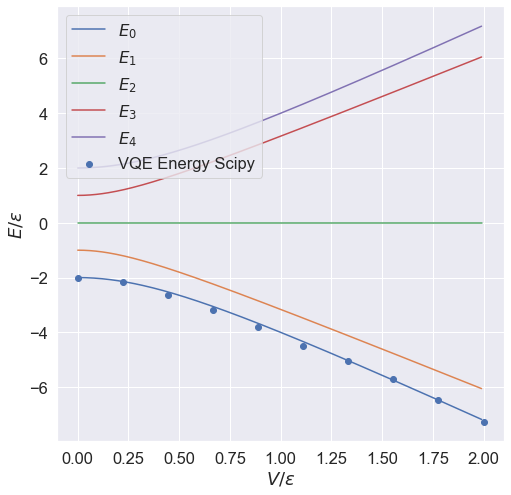

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'upper left')
plt.show()